In [78]:
import pandas as pd
import numpy as np
import os
import pickle
import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard


In [80]:
def load_data(path):
    df = pd.read_csv(path)
    return df

df = load_data("../data/Churn_Modelling.csv")  # Adjust path as per your file location
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [81]:
def encode_features(df):
    le_gender = LabelEncoder()
    df['Gender'] = le_gender.fit_transform(df['Gender'])

    ohe_geo = OneHotEncoder(sparse_output=False)
    geo_encoded = ohe_geo.fit_transform(df[['Geography']])
    geo_df = pd.DataFrame(geo_encoded, columns=ohe_geo.categories_[0])

    df = df.drop('Geography', axis=1)
    df = pd.concat([df, geo_df], axis=1)

    return df, le_gender, ohe_geo

df, le_gender, ohe_geo = encode_features(df)


In [82]:
def scale_and_split(df):
    X = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
    y = df['Exited']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, scaler

X_train, X_test, y_train, y_test, scaler = scale_and_split(df)


In [83]:
def build_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model(X_train.shape[1])


c:\Users\Prajwal B\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [84]:
def train_model(model, X_train, y_train, X_test, y_test):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=50, callbacks=[early_stop, tensorboard_cb])
    
    os.makedirs("artifacts", exist_ok=True)
    model.save("artifacts/model.h5")

    return model, history

model, history = train_model(model, X_train, y_train, X_test, y_test)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7682 - loss: 0.4981 - val_accuracy: 0.8365 - val_loss: 0.3845
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8355 - loss: 0.3915 - val_accuracy: 0.8530 - val_loss: 0.3549
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8543 - loss: 0.3510 - val_accuracy: 0.8515 - val_loss: 0.3507
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8584 - loss: 0.3429 - val_accuracy: 0.8545 - val_loss: 0.3461
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8571 - loss: 0.3460 - val_accuracy: 0.8580 - val_loss: 0.3476
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8630 - loss: 0.3423 - val_accuracy: 0.8565 - val_loss: 0.3431
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8687 - loss: 0.3172 - val_accuracy: 0.8585 - val_loss: 0.3407
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8595 - loss: 0.3350 - val_accuracy: 0.

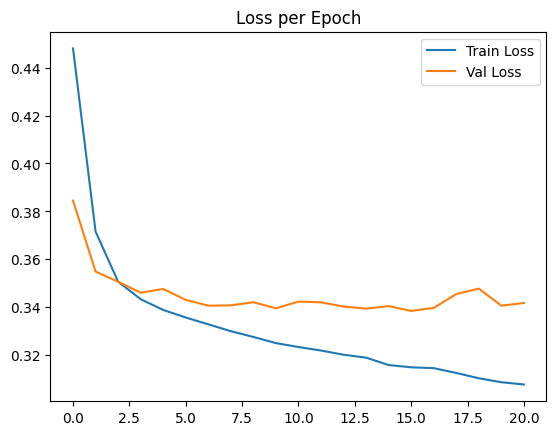

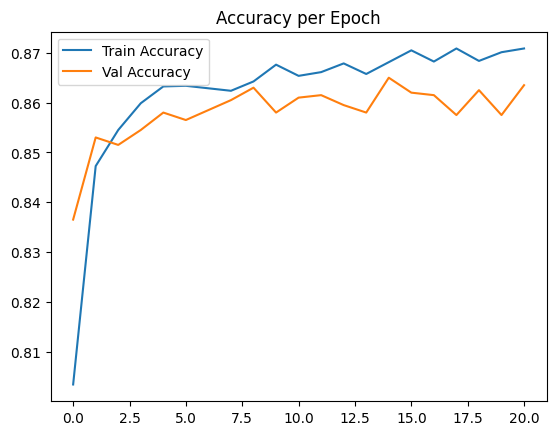

In [85]:
def plot_history(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss per Epoch')
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy per Epoch')
    plt.show()

plot_history(history)


In [86]:
with open("artifacts/label_encoder_gender.pkl", "wb") as f:
    pickle.dump(le_gender, f)

with open("artifacts/onehot_encoder_geo.pkl", "wb") as f:
    pickle.dump(ohe_geo, f)

with open("artifacts/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
